1. Importing Libraries

In [18]:
# Install if not already installed
# !pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from joblib import dump
import warnings

warnings.filterwarnings('ignore')  # Ignores warnings for cleaner output

# Display settings
pd.set_option('display.max_columns', None)


2. Loading the Dataset

In [19]:
# Load dataset 
df = pd.read_csv('Downloads/archive/heart.csv')

# Quick overview
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


3. Data Preprocessing

In [20]:
initial_rows = df.shape[0]
df = df[df['Cholesterol'] > 0]
removed_rows = initial_rows - df.shape[0]
print(f"Rows removed (Cholesterol = 0): {removed_rows}")
print(f"Remaining rows: {df.shape[0]}")

# 3.1 Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Basic statistics
print("\nDataset Description:\n")
print(df.describe())

# 3.2 Separate features (X) and target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# 3.3 Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f"Numerical Columns: {list(numerical_cols)}")
print(f"Categorical Columns: {list(categorical_cols)}")


Rows removed (Cholesterol = 0): 172
Remaining rows: 746

Missing Values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Dataset Description:

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  746.000000  746.000000   746.000000  746.000000  746.000000   
mean    52.882038  133.022788   244.635389    0.167560  140.226542   
std      9.505888   17.282750    59.153524    0.373726   24.524107   
min     28.000000   92.000000    85.000000    0.000000   69.000000   
25%     46.000000  120.000000   207.250000    0.000000  122.000000   
50%     54.000000  130.000000   237.000000    0.000000  140.000000   
75%     59.000000  140.000000   275.000000    0.000000  160.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  

4. Preprocessing pipeline

In [21]:
# Pipeline for numerical features: impute missing values + scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: impute + one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

print(f"Processed Feature Shape: {X_processed.shape}")


Processed Feature Shape: (746, 20)


5. Train-Test Split

In [22]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Train set shape: (596, 11)
Test set shape: (150, 11)


6. Build the Full Pipeline

In [23]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Full pipeline: preprocessing + model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])


7. Cross Validation

In [24]:
# 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("Cross Validation Results:")

for metric in scoring:
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=metric)
    print(f"{metric.capitalize()}: {scores.mean():.4f} (+/- {scores.std():.4f})")


Cross Validation Results:
Accuracy: 0.8725 (+/- 0.0223)
Precision: 0.8420 (+/- 0.0718)
Recall: 0.8984 (+/- 0.0383)
F1: 0.8669 (+/- 0.0387)
Roc_auc: 0.9294 (+/- 0.0080)


8. Train on Full Training Set 

In [25]:

pipeline.fit(X_train, y_train)

print("Model training completed!")


Model training completed!


9. Evaluate on Test Set

In [26]:
# Predict on test set
y_pred = pipeline.predict(X_test)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix, 
                       index=['Actual Negative', 'Actual Positive'], 
                       columns=['Predicted Negative', 'Predicted Positive'])

print("\nConfusion Matrix:")
print(conf_df)



Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        78
           1       0.86      0.89      0.88        72

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  68                  10
Actual Positive                   8                  64


10. Plot Confusion Matrix and ROC Curve

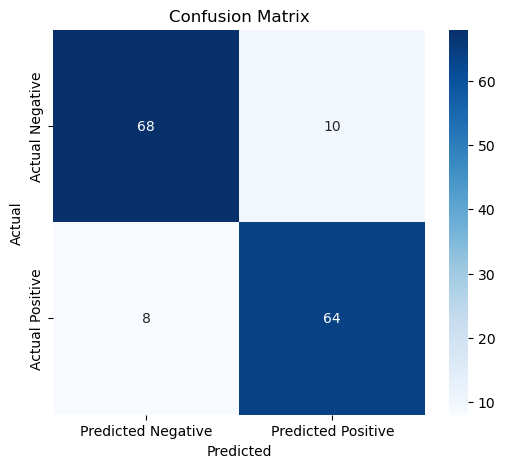

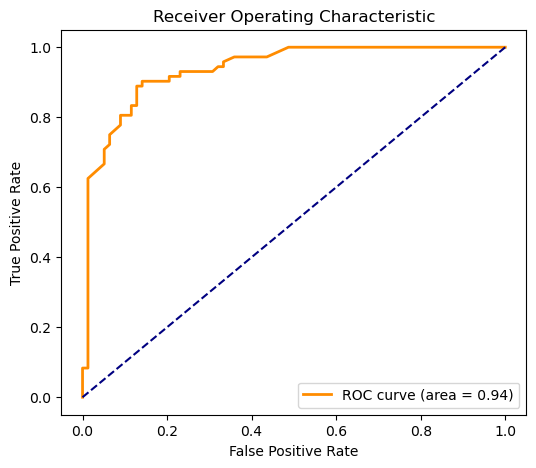

In [27]:
# Confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_prob = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Additional Scores

In [28]:
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score)
# Additional scores
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Test Accuracy: 0.8800
Test Precision: 0.8649
Test Recall: 0.8889
Test F1 Score: 0.8767
Test ROC AUC Score: 0.9374


In [29]:
# Save the trained pipeline (preprocessing + model)
dump(pipeline, 'heart_failure_model_RF.pkl')

print("Model saved successfully as 'heart_failure_model_RF.pkl'.")


Model saved successfully as 'heart_failure_model_RF.pkl'.
